In [9]:
import os
import glob
import json
import importlib
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns

In [10]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.arousal.dlc_utils as dlcutils
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.decoding as dec

In [11]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
fov_type = 'zoom2p0x'
state = 'awake'
traceid = 'traces001'

In [12]:
%matplotlib notebook

In [13]:
experiment = 'gratings'
trial_epoch = 'stimulus'
responsive_test='ROC'
# --------------------------------------------------------
response_type='dff'
if responsive_test=='nstds':
    responsive_thr=7.0 if experiment=='rfs' else 10.
else:
    responsive_thr=0.05 if responsive_test=='ROC' else responsive_thr
resp_desc = '%s_responsive-%s-thr%.2f' \
                % (response_type, responsive_test, responsive_thr)
data_id = '|'.join([traceid, resp_desc])
print(data_id)
# ------------------------------------------------------------------
# Load all metdata and assigned cells
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
experiment_list = ['rfs10', 'rfs'] if experiment=='rfs' else [experiment]
meta = sdata[sdata.experiment.isin(experiment_list)].copy()

traces001|dff_responsive-ROC-thr0.05
/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


In [14]:
C_value=1.0
test_split=0.2
cv_nfolds=5
chance_level = 1/8. if experiment=='gratings' else 0.5

In [17]:
analysis_type='by_fov' #'by_ncells' #'by_fov'
test_type='ori_single' #'size_single'
class_name = 'ori'
variation_name = None
match_rfs = False
overlap_thr= None #[0, 0.25, 0.5]

if test_type is None:
    test_str = 'default'
else:
    test_str = '%s_%s' % (test_type, variation_name) \
                    if variation_name is not None else test_type
basedir = os.path.join(aggregate_dir, 'decoding', 'py3_%s' % analysis_type,
                      class_name, test_str)
if not os.path.exists(basedir):
    os.makedirs(basedir)
    print(basedir)
print(basedir)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single


In [18]:
NDATA0 = aggr.load_responsive_neuraldata(experiment, meta=meta, 
                                    traceid=traceid,
                                    response_type=response_type, 
                                    trial_epoch=trial_epoch,
                                    responsive_test=responsive_test,
                                    responsive_thr=responsive_thr)
cells0 = aggr.get_all_responsive_cells(cells0, NDATA0)
# input data
NDATA = aggr.get_neuraldata_for_included_cells(cells0, NDATA0)

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_gratings_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking gratings configs


In [19]:
min_ncells = 10
counts_by_fov = aggr.count_n_cells(NDATA)
pass_n_cells = counts_by_fov[counts_by_fov.n_cells>=min_ncells]
too_few_cells = counts_by_fov[counts_by_fov.n_cells<min_ncells]

## Output dirs

In [20]:
aggr_id = dec.create_aggregate_id(C_value=C_value, 
                            trial_epoch=trial_epoch,
                            responsive_test=responsive_test,
                            match_rfs=match_rfs, overlap_thr=overlap_thr)
dst_dir = os.path.join(basedir, aggr_id)
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
print(dst_dir)
print(aggr_id)

FIGDIR = os.path.join(aggregate_dir, 'FIGURES', 'decoding')
if not os.path.exists(FIGDIR):
    os.makedirs(FIGDIR)

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single/dff-ROC__stimulus__noRF__C1.00
dff-ROC__stimulus__noRF__C1.00


## Load

In [21]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [23]:
experiment = 'gratings' 
print(analysis_type, test_type, class_name, variation_name)
iterdf, missing_ = dec.load_iterdf(meta, class_name,
                          experiment=experiment,
                          analysis_type=analysis_type,
                          test_type=test_type,
                          traceid=traceid,
                          trial_epoch=trial_epoch, responsive_test=responsive_test, 
                          C_value=C_value, break_correlations=False, 
                          match_rfs=match_rfs, overlap_thr=overlap_thr)
if match_rfs and (responsive_test=='ROC'):
    iterdf = iterdf[iterdf.n_cells<=96]

by_fov ori_single ori None
(V1) Found 8 paths
(Lm) Found 7 paths
(Li) Found 15 paths
    checking for break-corrs
(V1) Found 8 paths
(Lm) Found 7 paths
(Li) Found 15 paths


In [24]:
## Check that we have 1 for 1:
if 'noise_corrs' in iterdf.columns:
    df_a = iterdf[iterdf.noise_corrs=='intact']['datakey'].unique()
    df_b = iterdf[iterdf.noise_corrs=='shuffled']['datakey'].unique()
    print(len(df_a), len(df_b))

29 29


In [25]:
if len(df_a) != len(df_b):
    cond_w_less = 'shuffled' if len(df_a)>len(df_b) else 'intact'
    cond_w_more = 'intact' if cond_w_less=='shuffled' else 'shuffled'
    iterdf_og = iterdf.copy()
    i_list=[]
    df_a = iterdf_og[iterdf_og.noise_corrs==cond_w_more]
    df_b = iterdf_og[iterdf_og.noise_corrs==cond_w_less]
    for (va, dk), g in df_a.groupby(['visual_area', 'datakey']):
        if not df_b[(df_b.visual_area==va) & (df_b.datakey==dk)].empty:
            i_list.append(g)
            i_list.append(df_b[(df_b.visual_area==va) & (df_b.datakey==dk)])
        else:
            print(dk)
    iterdf = pd.concat(i_list, axis=0)

In [26]:
iterdf['noise_corrs'].unique()

array(['intact', 'shuffled'], dtype=object)

In [27]:
if 'train_transform' in iterdf.columns:
    iterdf['sf'] = [round(float(i.split('_')[0]), 1) for i in iterdf['train_transform'].values]
    iterdf['size'] = [int(float(i.split('_')[1])) for i in iterdf['train_transform'].values]
    iterdf['speed'] = [int(float(i.split('_')[2])) for i in iterdf['train_transform'].values]
    iterdf['size_type'] = ['fullfield' if i==200 else 'apertured' \
                          for i in iterdf['size'].values]

#### Check if don't have 1 low and 1 high config

In [28]:
import importlib

In [30]:
importlib.reload(gutils)

<module 'analyze2p.gratings.utils' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/gratings/utils.py'>

In [36]:
load_err_configs = True
parent_dir  = os.path.split(basedir)[0]
wrong_configs_file = os.path.join(parent_dir, 'incorrect_configs.json')
if load_err_configs:
    with open(wrong_configs_file, 'r') as f:
        err_configs = json.load(f)
else:
    iterdf, err_configs = gutils.check_high_low_param_values(iterdf)
#     err_configs = dict((k, []) for k in ['size', 'sf', 'speed'])
#     if 'train_transform' in iterdf.columns:
#         for param in ['size', 'sf', 'speed']:
#             iterdf['%s_rel' % param] = None
#         for (va, dk), g in iterdf.groupby(['visual_area','datakey']):
#             for param in ['size', 'sf', 'speed']:
#                 if len(g[param].unique())!=2:
#                     err_configs[param].append(dk)
#                     continue
#                 minv, maxv = sorted(g[param].unique())
#                 iterdf.loc[g[g[param]==minv].index, '%s_rel' % param] = 'low'
#                 iterdf.loc[g[g[param]==maxv].index, '%s_rel' % param] = 'high'
    with open(wrong_configs_file, 'w') as f:
        json.dump(err_configs, f, indent=4)

In [37]:
wrong_configs_by_param = err_configs.values()
wrong_configs = np.unique([item for sublist in wrong_configs_by_param \
                           for item in sublist])
wrong_configs

array(['20190306_JC061_fov2', '20190314_JC070_fov1',
       '20190315_JC070_fov2', '20190319_JC067_fov1',
       '20190321_JC070_fov2', '20190511_JC083_fov1',
       '20190512_JC083_fov1', '20190522_JC089_fov1',
       '20190527_JC092_fov3'], dtype='<U19')

In [40]:
# Exclude dkeys with wrong config
iterdf, _ = gutils.check_high_low_param_values(iterdf)
iterdf_x = iterdf[~(iterdf.datakey.isin(wrong_configs))].copy()

In [44]:
iterdf_x['novel'].unique()

array([False])

In [43]:
grouper = ['visual_area', 'condition', 'iteration']
if 'noise_corrs' in iterdf.columns:
    grouper.append('noise_corrs')
if 'train_transform' in iterdf.columns:
    grouper.extend(['sf', 'size', 'speed', 'train_transform'])
if analysis_type=='by_ncells':
    grouper.extend(['n_cells'])
mean_df0 = dec.average_within_iterations_by_ncells(iterdf_x, 
                            analysis_type=analysis_type, test_type=test_type,
                            grouper=grouper) 
if test_type is not None:
    score_table = mean_df0[ (mean_df0.condition=='data')]\
            .groupby(grouper)\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area', 'novel'], columns='noise_corrs')
else:
    columns='n_cells' if analysis_type=='by_ncells' else 'noise_corrs'
    score_table = mean_df0[(mean_df0.condition=='data')]\
            .groupby(grouper)\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index='visual_area', columns=columns)
print("EXP: %s (class=%s): %s" % (experiment, class_name, aggr_id))
score_table

EXP: gratings (class=ori): dff-ROC__stimulus__noRF__C1.00


heldout_test_score           iteration              sf  \
noise_corrs                   intact  shuffled    intact shuffled intact   
visual_area novel                                                          
Li          False           0.159622  0.160555     249.5    249.5    0.3   
Lm          False           0.283311  0.275022     249.5    249.5    0.3   
V1          False           0.304142  0.308749     249.5    249.5    0.3   

                             size           speed           
noise_corrs       shuffled intact shuffled intact shuffled  
visual_area novel                                           
Li          False      0.3     90       90     15       15  
Lm          False      0.3    115      115     15       15  
V1          False      0.3    110      110     15       15

In [45]:
grouper = ['visual_area', 'condition', 'iteration']
if 'train_transform' in iterdf.columns:
    grouper.extend(['sf', 'size', 'speed', 'train_transform'])
if 'noise_corrs' in iterdf.columns:
    grouper.extend(['noise_corrs'])
mean_df0 = dec.average_within_iterations_by_ncells(iterdf_x, 
                            analysis_type=analysis_type, test_type=test_type,
                            grouper=grouper) 

mean_df0[ (mean_df0.condition=='data')]\
            .groupby(grouper)\
            .mean()['heldout_test_score'].reset_index()\
            .pivot_table(index=['visual_area', 'noise_corrs'])

heldout_test_score  iteration  novel   sf  size  \
visual_area noise_corrs                                                    
Li          intact                 0.159622      249.5  False  0.3    90   
            shuffled               0.160555      249.5  False  0.3    90   
Lm          intact                 0.283311      249.5  False  0.3   115   
            shuffled               0.275022      249.5  False  0.3   115   
V1          intact                 0.304142      249.5  False  0.3   110   
            shuffled               0.308749      249.5  False  0.3   110   

                         speed  
visual_area noise_corrs         
Li          intact          15  
            shuffled        15  
Lm          intact          15  
            shuffled        15  
V1          intact          15  
            shuffled        15

# BY_NCELLS

In [385]:
max_ncells=201 if analysis_type=='by_ncells' else np.inf  # 96 if match_Rfs
special_cases = [169, 120, 46] # 169, test; 120: for match_rfs; 46: for testing overlap_thr

n_iters = iterdf[iterdf.n_cells==max_ncells]['iteration'].max() +1
sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells\
               and s not in special_cases]
xlabels = [1, 32, 64, 96, 128, max_ncells]
# grouper = ['visual_area', 'condition', 'iteration']

mean_df = mean_df0[mean_df0['n_cells'].isin(sample_sizes)]

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())

conditions: []


In [386]:
max_ncells = mean_df.groupby(['visual_area'])['n_cells'].max().min()
print(max_ncells)

nan


In [387]:
mean_df.groupby(['visual_area'])['n_cells'].max()

Series([], Name: n_cells, dtype: float64)

In [111]:
%matplotlib inline
metric='heldout_test_score'

if analysis_type=='by_ncells':
    plotd = mean_df[(mean_df['n_cells']<=max_ncells) 
                   & (mean_df['size']<200) 
                  & (mean_df['sf']==0.1) & (mean_df['speed']==20)].copy()
    # plotd.loc[~plotd['novel'], 'novel_labels'] = 'trained'
    #cond_colors = {'novel': 'cornflowerblue', 'trained': [0.3]*3}
    cond_styles = {'data': '', 'shuffled': (1,1)}
    fig, axn = pl.subplots(1,3, figsize=(6., 3), dpi=150, sharex=True, sharey=True)
    for vi, (va, df_) in enumerate(plotd.groupby('visual_area')):
        ai = visual_areas.index(va)
        ax=axn[ai]; ax.set_title(va);
        sns.lineplot(x='n_cells', y=metric, data=df_, ax=ax,
                style='condition', dashes=cond_styles, ci='sd', err_style='bars',
                color=area_colors[va], lw=0.5, 
                err_kws=dict(capsize=1, linewidth=0.5))
        ax.legend_.remove()
    axn[-1].legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)

    pl.subplots_adjust(left=0.07, right=0.8, bottom=0.25, top=0.7,
                          wspace=0.2)
    for ax in axn:
        #ax.set_yticks(np.linspace(0.4, 1, 4))
        #ax.set_ylim([0.4,1])
        ax.set_xticks(sample_sizes)
        ax.set_box_aspect(1)
        ax.set_xticklabels([i if i in xlabels else '' for i in sample_sizes])
    sns.despine(trim=True)

    fig.text(0.01, 0.85, '[%s] Test scores on novel vs. trained, sd over n=%i iters' \
             % (experiment, n_iters), fontsize=8)
    pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))

    figname = 'trained_v_novel_byncells__%s' % experiment
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
    pl.savefig(os.path.join(FIGDIR,  '%s.svg' % figname))

    print(dst_dir, figname)

In [112]:
aggr_id

'dff-ROC__stimulus__noRF__C1.00'

# by_fov

In [46]:
iterdf['n_cells'].unique()

array([ 22,  10,   2,   4,   9,  20,  72,  50,  38,  59,  14,  35,  24,
        41, 110, 103,  60,  76,  30, 101,  18, 129,  91, 186,  98, 171,
        89])

In [47]:
drop_wrong_configs=True

print(analysis_type, test_type)
# grouper = ['visual_area', 'condition', 'datakey', 'intact']
grouper = ['visual_area', 'condition', 'datakey', 'intact']
if 'train_transform' in iterdf.columns:
    grouper.extend(['sf', 'size_type', 'speed','train_transform'])
    grouper.extend(['size_rel', 'sf_rel', 'speed_rel'])
    
iterdf_pass = iterdf[(iterdf.n_cells>min_ncells)].copy()
print("N datakeys that pass min_ncells>=%i:" % min_ncells)
print(iterdf_pass[['visual_area', 'datakey']]\
    .drop_duplicates()['visual_area'].value_counts().to_string())

if drop_wrong_configs:
    config_str = 'drop-wrong-configs'
    iterdf_x = iterdf_pass[~(iterdf_pass['datakey'].isin(wrong_configs))]
else:
    config_str = 'okay-wrong-configs'
    iterdf_x = iterdf_pass[~(iterdf_pass.datakey.isin(wrong_configs))]
mean_df = dec.average_across_iterations_by_fov(iterdf_x,
                        analysis_type=analysis_type, test_type=test_type,
                        grouper=grouper)
print("Final N datakeys that pass:")
print(mean_df[['visual_area', 'datakey']]\
    .drop_duplicates()['visual_area'].value_counts().to_string())

if test_type is not None:
    print("novel:", mean_df['novel'].unique())
print("conditions:", mean_df['condition'].unique())
print("intact/break_cc:", mean_df['intact'].unique())

by_fov ori_single
N datakeys that pass min_ncells>=10:
Li    11
V1     8
Lm     7
Final N datakeys that pass:
Li    9
V1    6
Lm    5
novel: [False]
conditions: ['data' 'shuffled']
intact/break_cc: [False  True]


In [48]:
print(iterdf_pass[['visual_area', 'datakey']]\
    .drop_duplicates()['visual_area'].value_counts().to_string())

Li    11
V1     8
Lm     7


In [49]:
match_ncells=False
# ---------------------------------
all_counts = mean_df[['visual_area', 'datakey', 'n_cells']].drop_duplicates()
max_ncells = all_counts.groupby('visual_area')['n_cells'].max().min() if match_ncells\
                else all_counts.groupby('visual_area')['n_cells'].max().max() 
min_ncells = all_counts.groupby('visual_area')['n_cells'].min().max() if match_ncells\
                else 10
print(min_ncells, max_ncells)
# Get sample sizes
n_iters = iterdf['iteration'].max() +1
sample_sizes = [s for s in sorted(iterdf['n_cells'].unique()) if s <=max_ncells]
xlabels = [1, 32, 96, max_ncells]
# filter too few/too many cells
fov_filter_str = 'matchNcells' if match_ncells else 'allcells'
passdf = mean_df[(mean_df['n_cells']>=min_ncells) 
                    & (mean_df['n_cells']<=max_ncells)].copy()
counts = passdf[['visual_area', 'datakey', 'n_cells']].copy().drop_duplicates()
# Drop repeat FOVs based on N fits
u_dkeys = aggr.drop_repeats(counts, criterion='max', colname='n_cells')
finaldf = pd.concat([g for (va, dk), g in passdf.groupby(['visual_area', 'datakey'])\
                if (va, dk) in u_dkeys])
# Add some extralabels
passdf['noise_corrs'] = ['intact' if f else 'shuffled' for f in passdf['intact'].values]
finaldf['noise_corrs'] = ['intact' if f else 'shuffled' for f in finaldf['intact'].values]

print("Final N datakeys that pass (DROP REPEATS):")
print(finaldf[['visual_area', 'datakey']]\
    .drop_duplicates()['visual_area'].value_counts().to_string())


10 186.0
Final N datakeys that pass (DROP REPEATS):
Li    6
V1    6
Lm    5


In [146]:
#### Final NDATA
ndata_final = pd.concat([g for (va, dk), g in NDATA.groupby(['visual_area', 'datakey'])\
                if (va, dk) in u_dkeys])

<IPython.core.display.Javascript object>


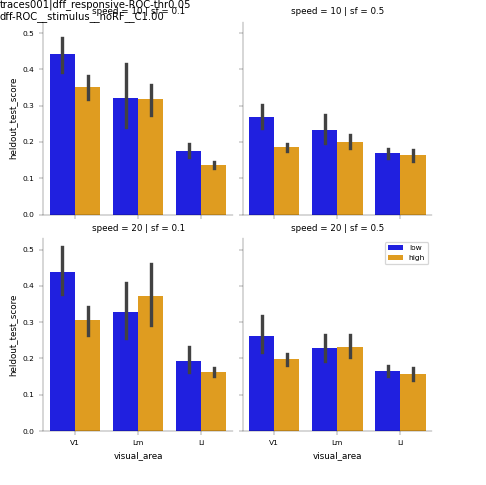

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


In [50]:
%matplotlib notebook
sf_colors={0.1: 'blue', 0.5: 'orange'}
size_colors={'fullfield': 'blue', 'apertured': 'orange'}
size_rel_colors={'low': 'blue', 'high': 'orange'}

df_ =finaldf[finaldf.condition=='data']
metric='heldout_test_score'
fg = sns.FacetGrid(col='sf', row='speed', data=df_, height=3)
fg.map(sns.barplot, 'visual_area', metric, 'size_rel', palette=size_rel_colors,
      order=visual_areas, hue_order=['low', 'high'])
pl.legend()
pl.subplots_adjust(bottom=0.2, right=0.8)


<IPython.core.display.Javascript object>


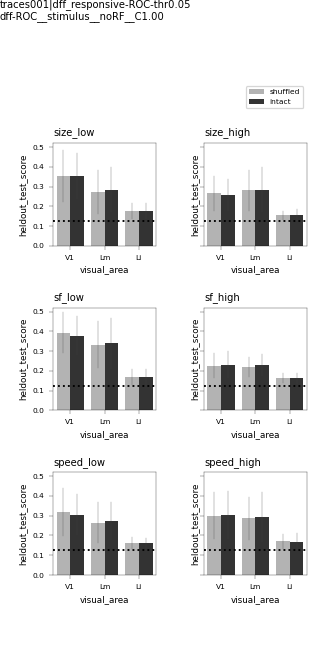

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single/dff-ROC__stimulus__noRF__C1.00 split_by_config_acc_intact-v-shuff-corrs


In [64]:
corr_colors={'intact': [0.2]*3, 'shuffled': [0.7]*3}
df_ =finaldf[finaldf.condition=='data']

fig, axn = pl.subplots(3, 2, figsize=(4, 8), sharey=True)
for pi, param_name in enumerate(['size', 'sf', 'speed']):
    for vi, param_val in enumerate(['low', 'high']):
        ax=axn[pi, vi]
        ax.set_title('%s_%s' % (param_name, param_val), loc='left', fontsize=8)
        sns.barplot(x='visual_area', y=metric, ax=ax, 
                    data=df_[df_['%s_rel' % param_name]==param_val],
                    hue='noise_corrs', palette=corr_colors,
                    order=visual_areas, ci='sd', errwidth=0.25)
        if pi==0 and vi==1:
            ax.legend(bbox_to_anchor=(1,1.3), loc='lower right')
        else:
            ax.legend_.remove()
for ax in axn.flat:
    ax.set_box_aspect(1)
    ax.axhline(y=chance_level, ls=':', color='k')
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.2, top=0.8, wspace=0.1, hspace=0.6)

pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
figname = 'split_by_config_acc_intact-v-shuff-corrs'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [222]:
hue_values

[False]

In [130]:
%matplotlib notebook
if analysis_type=='by_fov' and test_type not in [None, 'ori_single']:
    plotd0 = finaldf[(finaldf['intact'])].copy()
    plotd = plotd0.groupby(['visual_area', 'datakey','condition'])\
                    .mean().reset_index()
    hue_column = 'novel' if test_type=='' is not None else 'intact'
    hue_values = sorted(plotd[hue_column].unique())
    cond_colors = {hue_values[0]: [0.3]*3, hue_values[1]: [0.7]*3}    

    metric = 'heldout_test_score'
    fig, axn = pl.subplots(1, 2, figsize=(5.5,3), sharex=True, sharey=True)
    for ai, (cond, df_) in enumerate(plotd.groupby('condition')):
        title = 'true_targets' if cond=='data' else 'shuffled_targets'
        ai = 0 if cond=='data' else 1
        ax=axn[ai]; ax.set_title(title)
        sns.barplot(x='visual_area', y=metric, ax=ax, data=df_,
                   hue=hue_column, palette=cond_colors, ci='sd',
                   order=visual_areas)
        ax.legend_.remove()
    ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False,
             title=hue_column)
    pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
    ax.set_ylim([0, 1])

    sns.despine(trim=True)
    pl.subplots_adjust(left=0.1, right=0.8, bottom=0.2, top=0.8, wspace=0.3)
    figname = 'scores_avg_fov__%s' % aggr_id
    # pl.savefig(os.path.join(curr_dst_dir, '%s.svg' % figname))
    print(curr_dst_dir, figname)

In [226]:
hue_values

[True]

#### Paired accuracies: compare intact v shuffled noise-corrs

In [132]:
too_few_cells

,visual_area,datakey,n_cells
2,Li,20190319_JC067_fov1,2
3,Li,20190321_JC070_fov2,4
4,Li,20190522_JC089_fov1,9


In [133]:
finaldf.head()

,visual_area,condition,datakey,intact,sf,size_type,speed,train_transform,size_rel,sf_rel,...,heldout_test_score,C,randi,n_trials,iteration,n_cells,size,noise_corrs,train_transform_num,train_transform_rel
0,Li,data,20190602_JC091_fov1,False,0.1,apertured,10,0.1_30.0_10.0,low,low,...,0.220000,1.0,4921.684,160.0,249.5,72.0,30.0,shuffled,0.1_30.0_10.0,low_low_low
1,Li,data,20190602_JC091_fov1,False,0.1,apertured,20,0.1_30.0_20.0,low,low,...,0.314625,1.0,5116.186,160.0,249.5,72.0,30.0,shuffled,0.1_30.0_20.0,low_low_high
2,Li,data,20190602_JC091_fov1,False,0.1,fullfield,10,0.1_200.0_10.0,high,low,...,0.157500,1.0,4946.072,160.0,249.5,72.0,200.0,shuffled,0.1_200.0_10.0,low_high_low
3,Li,data,20190602_JC091_fov1,False,0.1,fullfield,20,0.1_200.0_20.0,high,low,...,0.167250,1.0,5105.470,160.0,249.5,72.0,200.0,shuffled,0.1_200.0_20.0,low_high_high
4,Li,data,20190602_JC091_fov1,False,0.5,apertured,10,0.5_30.0_10.0,low,high,...,0.181562,1.0,4991.388,160.0,249.5,72.0,30.0,shuffled,0.5_30.0_10.0,high_low_low


In [134]:
maindf = finaldf.copy()

if test_type=='ori_single':
    paired_df = maindf[(maindf.sf==0.1)]\
                .groupby(['visual_area', 'datakey', 'noise_corrs', 
                          'condition']).mean()\
                .reset_index()
else:
    paired_df = maindf\
            .groupby(['visual_area', 'datakey', 'noise_corrs', 
                      'condition']).mean()\
            .reset_index()

In [135]:
paired_df.groupby(['visual_area', 'datakey']).count()

noise_corrs  condition  intact  sf  speed  \
visual_area datakey                                                          
Li          20190602_JC091_fov1            4          4       4   4      4   
            20190612_JC099_fov1            4          4       4   4      4   
            20190614_JC091_fov1            4          4       4   4      4   
            20190617_JC099_fov1            4          4       4   4      4   
            20191018_JC113_fov1            4          4       4   4      4   
            20191111_JC120_fov1            4          4       4   4      4   
Lm          20190513_JC078_fov1            4          4       4   4      4   
            20190525_JC084_fov1            4          4       4   4      4   
            20190603_JC080_fov1            4          4       4   4      4   
            20190618_JC097_fov1            4          4       4   4      4   
            20190627_JC091_fov1            4          4       4   4      4   
V1          20190522_JC084_fov1            4          4       4   4      4   
            20190613_JC097_fov1            4          4       4   4      4   
            20190616_JC097_fov1            4          4       4   4      4   
            20190617_JC097_fov1            4          4       4   4      4   
            20190622_JC085_fov1            4          4       4   4      4   
            20191006_JC110_fov1            4          4       4   4      4   

                                 novel  fit_time  score_time  test_score  \
visual_area datakey                                                        
Li          20190602_JC091_fov1      4         4           4           4   
            20190612_JC099_fov1      4         4           4           4   
            20190614_JC091_fov1      4         4           4           4   
            20190617_JC099_fov1      4         4           4           4   
            20191018_JC113_fov1      4         4           4           4   
            20191111_JC120_fov1      4         4           4           4   
Lm          20190513_JC078_fov1      4         4           4           4   
            20190525_JC084_fov1      4         4           4           4   
            20190603_JC080_fov1      4         4           4           4   
            20190618_JC097_fov1      4         4           4           4   
            20190627_JC091_fov1      4         4           4           4   
V1          20190522_JC084_fov1      4         4           4           4   
            20190613_JC097_fov1      4         4           4           4   
            20190616_JC097_fov1      4         4           4           4   
            20190617_JC097_fov1      4         4           4           4   
            20190622_JC085_fov1      4         4           4           4   
            20191006_JC110_fov1      4         4           4           4   

                                 train_score  heldout_test_score  C  randi  \
visual_area datakey                                                          
Li          20190602_JC091_fov1            4                   4  4      4   
            20190612_JC099_fov1            4                   4  4      4   
            20190614_JC091_fov1            4                   4  4      4   
            20190617_JC099_fov1            4                   4  4      4   
            20191018_JC113_fov1            4                   4  4      4   
            20191111_JC120_fov1            4                   4  4      4   
Lm          20190513_JC078_fov1            4                   4  4      4   
            20190525_JC084_fov1            4                   4  4      4   
            20190603_JC080_fov1            4                   4  4      4   
            20190618_JC097_fov1            4                   4  4      4   
            20190627_JC091_fov1            4                   4  4      4   
V1          20190522_JC084_fov1            4                   4  4      4   
            2

In [136]:
paired_df[paired_df.datakey=='20190616_JC097_fov1']

,visual_area,datakey,noise_corrs,condition,intact,sf,speed,novel,fit_time,score_time,test_score,train_score,heldout_test_score,C,randi,n_trials,iteration,n_cells,size
52,V1,20190616_JC097_fov1,intact,data,True,0.1,15.0,False,0.002839,0.000527,0.404476,1.0,0.430422,1.0,4974.2570,160.0,249.5,186.0,110.0
53,V1,20190616_JC097_fov1,intact,shuffled,True,0.1,15.0,False,0.002906,0.000529,0.125830,1.0,0.123687,1.0,4974.2570,160.0,249.5,186.0,110.0
54,V1,20190616_JC097_fov1,shuffled,data,False,0.1,15.0,False,0.002773,0.000542,0.441350,1.0,0.455359,1.0,5054.8255,160.0,249.5,186.0,110.0
55,V1,20190616_JC097_fov1,shuffled,shuffled,False,0.1,15.0,False,0.002795,0.000541,0.124193,1.0,0.124375,1.0,5054.8255,160.0,249.5,186.0,110.0


In [137]:
iterdf[iterdf.datakey=='20190616_JC097_fov1']['intact'].unique()

array([ True, False])

In [138]:
# rerun = ['20190306_JC061_fov2', '20190522_JC089_fov1', 
#  '20190315_JC070_fov2', '20190314_JC070_fov1']
# paired_df = meandf[~meandf.datakey.isin(rerun)]

<IPython.core.display.Javascript object>


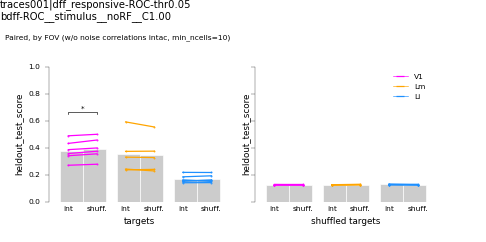

   t_stat  p_val visual_area
0     0.0  0.031          V1
   t_stat  p_val visual_area condition
0     0.0   0.03          V1      data
1     4.0   0.44          Lm      data
2     9.0   0.84          Li      data
0     9.0   0.84          V1  shuffled
1     0.0   0.06          Lm  shuffled
2     4.0   0.22          Li  shuffled
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single/dff-ROC__stimulus__noRF__C1.00 paired_accuracy_break_noisecorrs_heldout_test_score


In [139]:
%matplotlib notebook

metric='heldout_test_score'
if analysis_type=='by_fov':
    s_=[]
    corr_colors={'intact': 'darkblue', 'shuffled': 'lightblue'}
    fig, axn = pl.subplots(1,2, figsize=(6,3), sharex=True, sharey=True)
    for ai, (cond, datad) in enumerate(paired_df.groupby('condition')):
        ax=axn[ai]
        ax, pstats = pplot.pairwise_compare_single_metric(datad, 
                         curr_metric=metric, ax=ax, bar_ci=None,
                         c1='intact', c2='shuffled', compare_var='noise_corrs',
                         return_stats=True, marker='.', size=1, edgecolor=['w']*3,
                         facecolor=[0.8]*3, annotate=True, sig_lw=0.5,ttest=False,
                         sig_fontsize=6, sig_height=0.01, sig_offset=None)
        pstats['condition'] = cond
        s_.append(pstats)
statsdf = pd.concat(s_, axis=0)
print(statsdf.round(2))

pl.subplots_adjust(left=0.1, right=0.8, bottom=0.25, top=0.75)
for ai, ax in enumerate(axn):
    ax.set_xlabel('')
    ax.set_ylim([0, 1])
    xtick_labels = ['int', 'shuff.']*3
    ax.set_xlabel('targets') if ai==0 else ax.set_xlabel('shuffled targets')
    ax.set_xticklabels(xtick_labels)
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                   labels=visual_areas, markers='_')
axn[1].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='upper right', frameon=False)

fig.text(0.01, 0.85, \
    'Paired, by FOV (w/o noise correlations intac, min_ncells=%i)' % min_ncells)
pplot.label_figure(fig, '%s\nb%s' % (data_id, aggr_id))
figname = 'paired_accuracy_break_noisecorrs_%s' % metric
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [142]:
SDF, incorrect_stim = aggr.check_sdfs(NDATA0['datakey'].unique(), 
                            experiment=experiment,
                            images_only=False, rename=False,
                            return_incorrect=True, return_all=False)
incorrect_stim

Checking gratings configs


{'20190314_JC070_fov1':           direction luminance  stimtype xpos ypos  ori position speed   sf  \
 config001         0      None  gratings  0.0  0.0    0   (0, 0)    10  0.1   
 config002         0      None  gratings  0.0  0.0   45   (0, 0)    10  0.1   
 config003         0      None  gratings  0.0  0.0   90   (0, 0)    10  0.1   
 config004         0      None  gratings  0.0  0.0  135   (0, 0)    10  0.1   
 config005         0      None  gratings  0.0  0.0  180   (0, 0)    10  0.1   
 config006         0      None  gratings  0.0  0.0  225   (0, 0)    10  0.1   
 config007         0      None  gratings  0.0  0.0  270   (0, 0)    10  0.1   
 config008         0      None  gratings  0.0  0.0  315   (0, 0)    10  0.1   
 
            size  
 config001  60.0  
 config002  60.0  
 config003  60.0  
 config004  60.0  
 config005  60.0  
 config006  60.0  
 config007  60.0  
 config008  60.0  ,
 '20190315_JC070_fov2':           direction luminance  stimtype  xpos ypos  ori position spe

In [140]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single/dff-ROC__stimulus__noRF__C1.00'

# Final plots

## noise_corrs

In [143]:
import analyze2p.correlations as cr

In [144]:
experiment

'gratings'

In [147]:
select_stimuli='all'
min_ncells=10
distance_var='cortical_distance'
if 'experiment' not in ndata_final.columns:
    ndata_final['experiment'] = experiment
DISTS = cr.aggregate_ccdist(ndata_final, experiment=experiment, rfdf=None, rfpolys=None,
                    SDF=SDF, select_stimuli=select_stimuli,min_ncells=min_ncells,
                    distance_var=distance_var, verbose=True)

Dist: cortical_distance
Li 20190602_JC091_fov1 gratings
Li 20190612_JC099_fov1 gratings
Li 20190614_JC091_fov1 gratings
Li 20190617_JC099_fov1 gratings
Li 20191018_JC113_fov1 gratings
Li 20191111_JC120_fov1 gratings
Lm 20190513_JC078_fov1 gratings
Lm 20190525_JC084_fov1 gratings
Lm 20190603_JC080_fov1 gratings
Lm 20190618_JC097_fov1 gratings
Lm 20190627_JC091_fov1 gratings
V1 20190522_JC084_fov1 gratings
V1 20190613_JC097_fov1 gratings
V1 20190616_JC097_fov1 gratings
V1 20190617_JC097_fov1 gratings
V1 20190622_JC085_fov1 gratings
V1 20191006_JC110_fov1 gratings
1 datasets w wrong configs:
    ('Lm', '20190513_JC078_fov1')
0 datasets w/out RF fits:


In [148]:
meancc = DISTS.groupby(['visual_area', 'datakey']).median().reset_index()
meancc.head()

,visual_area,datakey,cell_1,cell_2,signal_cc,noise_cc,cortical_distance,n_cells
0,Li,20190602_JC091_fov1,43,87,0.341410,0.095672,226.638741,72
1,Li,20190612_JC099_fov1,108,223,0.168227,0.046209,277.343601,50
2,Li,20190614_JC091_fov1,52,253,0.420034,0.070467,233.632921,59
3,Li,20190617_JC099_fov1,25,43,0.079030,0.062154,268.971176,14
4,Li,20191018_JC113_fov1,95,131,0.166574,0.115026,238.073910,35


In [174]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

<IPython.core.display.Javascript object>


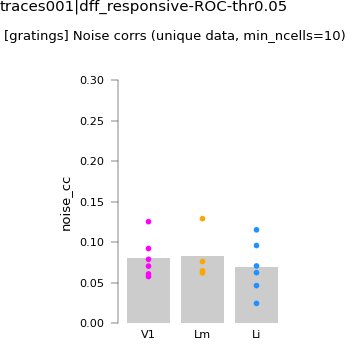

    A   B  Paired  Parametric  U-val       Tail  p-corr p-adjust  eta-square
0  Li  Lm   False       False    9.0  two-sided     1.0   fdr_by    0.043406
1  Li  V1   False       False   15.0  two-sided     1.0   fdr_by    0.038273
2  Lm  V1   False       False   13.0  two-sided     1.0   fdr_by    0.001423
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single/dff-ROC__stimulus__noRF__C1.00 noise_corrs_gratings


In [175]:
%matplotlib notebook
fig, stats_ = pplot.plot_standard_panel(meancc, 'noise_cc',
                               posthoc='fdr_by', return_stats=True)
ignore_cols=['Contrast', 'p-unc', 'metric']
print_cols=[p for p in stats_.columns if p not in ignore_cols]
print(stats_[print_cols].to_string())

fig.axes[0].set_ylim([0, 0.3])
fig.text(0.01, 0.9, '[%s] Noise corrs (unique data, min_ncells=%i)' \
         % (experiment, min_ncells), fontsize=7)
pplot.label_figure(fig, data_id)

figname = 'noise_corrs_%s' % experiment
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

## Calculate scores over chance

In [176]:
metric='heldout_test_score'
compare_var = 'noise_corrs'
# c1, c2 = sorted(vg[compare_var].unique())
c1 = 'shuffled'
c2 = 'intact'
scores_over_chance = dec.calculate_relative_scores(paired_df, compare_var=compare_var,
                                                  c1=c1, c2=c2, metric=metric)

In [177]:
df_ = scores_over_chance[~scores_over_chance.datakey.isin(incorrect_stim)]

In [178]:
importlib.reload(pplot)

<module 'analyze2p.plotting' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/plotting.py'>

<IPython.core.display.Javascript object>


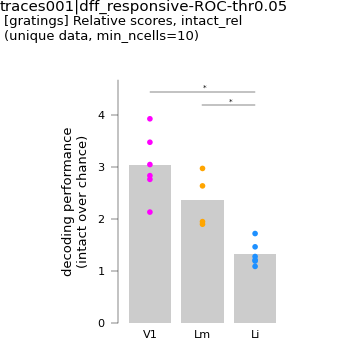

    A   B  Paired  Parametric  U-val       Tail    p-corr p-adjust  eta-square
0  Li  Lm   False       False    0.0  two-sided  0.039089   fdr_by    0.662922
1  Li  V1   False       False    0.0  two-sided  0.027912   fdr_by    0.768748
2  Lm  V1   False       False    4.0  two-sided  0.201336   fdr_by    0.243483
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single/dff-ROC__stimulus__noRF__C1.00 rel_scores_intact_rel-corrs_gratings


In [179]:
%matplotlib notebook
posthoc = 'fdr_by'
metric = 'intact_rel'
# ---------------------
fig, stats_ = pplot.plot_standard_panel(df_, metric, posthoc=posthoc, return_stats=True)
ignore_cols=['Contrast', 'p-unc', 'metric']
print_cols=[p for p in stats_.columns if p not in ignore_cols]
print(stats_[print_cols].to_string())

fig.axes[0].set_ylabel('decoding performance\n(intact over chance)')
fig.text(0.01, 0.9, '[%s] Relative scores, %s\n(unique data, min_ncells=%i)' \
         % (experiment, metric, min_ncells), fontsize=7)
pplot.label_figure(fig, data_id)

figname = 'rel_scores_%s-corrs_%s' % (metric, experiment)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


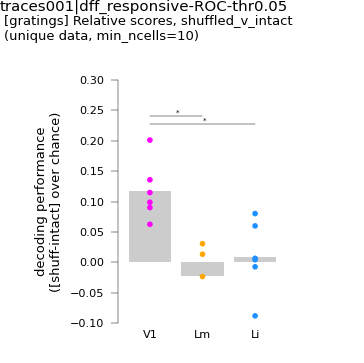

    A   B  Paired  Parametric  U-val       Tail    p-corr p-adjust  eta-square
0  Li  Lm   False       False   15.0  two-sided  1.000000   fdr_by    0.064792
1  Li  V1   False       False    1.0  two-sided  0.039089   fdr_by    0.502539
2  Lm  V1   False       False    0.0  two-sided  0.039089   fdr_by    0.625602
/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single/dff-ROC__stimulus__noRF__C1.00 rel_scores_shuffled_v_intact-corrs_gratings


In [180]:
%matplotlib notebook
posthoc = 'fdr_by'
metric = 'shuffled_v_intact'
# ---------------------
fig, stats_ = pplot.plot_standard_panel(df_, metric, posthoc=posthoc,
                                       return_stats=True)
ignore_cols=['Contrast', 'p-unc', 'metric']
print_cols=[p for p in stats_.columns if p not in ignore_cols]
print(stats_[print_cols].to_string())

fig.axes[0].set_ylabel('decoding performance\n([shuff-intact] over chance)')

fig.axes[0].set_ylim([-0.1, 0.3])
fig.text(0.01, 0.9, '[%s] Relative scores, %s\n(unique data, min_ncells=%i)' \
         % (experiment, metric, min_ncells), fontsize=7)
pplot.label_figure(fig, data_id)

figname = 'rel_scores_%s-corrs_%s' % (metric, experiment)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

#### Split by CONFIG:  compare intact vs. shuffled noise-corrs, if test_type is not None

In [181]:
finaldf['train_transform_num'] = finaldf['train_transform'].values
finaldf['train_transform_rel'] = ['_'.join([sf, sz, sp]) for sf, sz, sp \
                                 in finaldf[['sf_rel', 'size_rel', 'speed_rel']].values]
finaldf.head()

,visual_area,condition,datakey,intact,sf,size_type,speed,train_transform,size_rel,sf_rel,...,heldout_test_score,C,randi,n_trials,iteration,n_cells,size,noise_corrs,train_transform_num,train_transform_rel
0,Li,data,20190602_JC091_fov1,False,0.1,apertured,10,0.1_30.0_10.0,low,low,...,0.220000,1.0,4921.684,160.0,249.5,72.0,30.0,shuffled,0.1_30.0_10.0,low_low_low
1,Li,data,20190602_JC091_fov1,False,0.1,apertured,20,0.1_30.0_20.0,low,low,...,0.314625,1.0,5116.186,160.0,249.5,72.0,30.0,shuffled,0.1_30.0_20.0,low_low_high
2,Li,data,20190602_JC091_fov1,False,0.1,fullfield,10,0.1_200.0_10.0,high,low,...,0.157500,1.0,4946.072,160.0,249.5,72.0,200.0,shuffled,0.1_200.0_10.0,low_high_low
3,Li,data,20190602_JC091_fov1,False,0.1,fullfield,20,0.1_200.0_20.0,high,low,...,0.167250,1.0,5105.470,160.0,249.5,72.0,200.0,shuffled,0.1_200.0_20.0,low_high_high
4,Li,data,20190602_JC091_fov1,False,0.5,apertured,10,0.5_30.0_10.0,low,high,...,0.181562,1.0,4991.388,160.0,249.5,72.0,30.0,shuffled,0.5_30.0_10.0,high_low_low


In [182]:
curr_grouper = ['visual_area', 'datakey', 'noise_corrs', 'condition']
curr_grouper.extend(['train_transform_rel'])
df = finaldf[~(finaldf.novel)]\
            .groupby(curr_grouper).mean()\
            .reset_index()
# ===============================
compare_var='noise_corrs'
metric='heldout_test_score'
c1 = 'shuffled'
c2 = 'intact'
s_=[]
for train_transform, df_ in df.groupby('train_transform_rel'):
    split_ = dec.calculate_relative_scores(df_.copy(), metric=metric,
                                            compare_var=compare_var,
                                            c1=c1, c2=c2)
    split_['train_transform_rel'] = train_transform
    s_.append(split_)
split_scores = pd.concat(s_, axis=0, ignore_index=True)

<IPython.core.display.Javascript object>


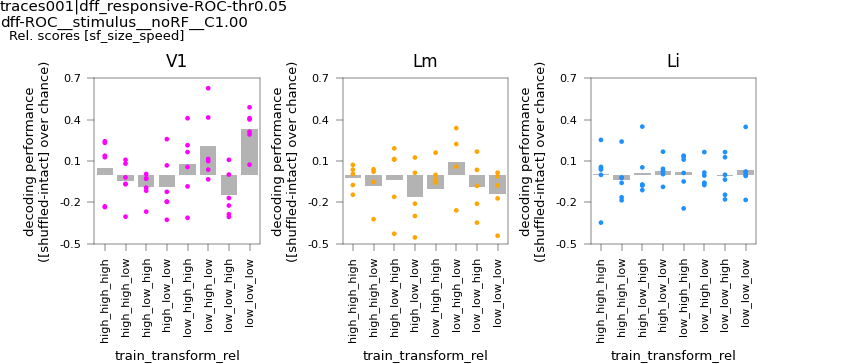

/n/coxfs01/julianarhee/aggregate-visual-areas/decoding/py3_by_fov/ori/ori_single/dff-ROC__stimulus__noRF__C1.00 split_by_config_acc-over-chance_intact-v-shuff-corrs


In [183]:
fig, axn=pl.subplots(1, 3, figsize=(7,3), dpi=150, sharex=True, sharey=False)
for va, vg in split_scores.groupby('visual_area'):
    ax = axn[visual_areas.index(va)]
    sns.barplot(x='train_transform_rel', y='shuffled_v_intact', data=vg, ax=ax,
            color=[0.7]*3, ci=None)
    sns.stripplot(x='train_transform_rel', y='shuffled_v_intact', data=vg, ax=ax,
            hue='visual_area', palette=area_colors, jitter=False,
            size=5, marker='.')
    ax.set_title(va)
    ax.legend_.remove()
ymin=-0.5
ymax=0.7
for ax in axn.flat:
    ax.set_box_aspect(1)
    ax.set_ylim([ymin, ymax])
    ax.set_yticks(np.linspace(ymin, ymax, 5))
    ax.set_yticklabels([round(i, 1) for i in np.linspace(ymin, ymax, 5)])
    ax.set_ylabel('decoding performance\n([%s-%s] over chance)' % (c1, c2))
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
pl.subplots_adjust(left=0.1, right=0.8, bottom=0.3, top=0.9, wspace=0.5)
fig.text(0.01, 0.9, 'Rel. scores [sf_size_speed]', fontsize=7)
pplot.label_figure(fig, '%s\n%s' % (data_id, aggr_id))
figname = 'split_by_config_acc-over-chance_intact-v-shuff-corrs'
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [184]:
840*2.

1680.0

# Example FOV

In [513]:
print(experiment)
dk = '20191006_JC110_fov1'
va = 'V1'

nmetrics = NDATA0[(NDATA0.visual_area==va) & (NDATA0.datakey==dk)].copy()

gratings


In [10]:
# dk = '20190616_JC097_fov1'
# va = 'V1'
print(experiment)
sdf = aggr.get_master_sdf(experiment)

blobs


In [11]:
class_name='morphlevel' if experiment=='blobs' else 'ori'
if experiment=='gratings':
    variation_name = None
else:
    variation_name = None if test_type is None else 'size'
variation_values=None
class_a = 0 if class_name=='morphlevel' else None
class_b = 106 if class_name=='morphlevel' else None
print(class_name, class_a, class_b)
class_values = [class_a, class_b] if class_name=='morphlevel' \
            else sdf[class_name].unique()
in_args={'class_name': class_name,
            'class_values': class_values,
            'variation_name': variation_name,
            'variation_values': variation_values,
            'n_train_configs': None,
            'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'balance_configs':True,
            'do_shuffle': True,
            'return_clf': False,
            'verbose': False}

morphlevel 0 106


In [514]:
# stimuli
sdf = aggr.get_stimuli(dk, experiment)
# zscore data
ndf_z = aggr.get_zscored_from_ndf(nmetrics)
n_cells = int(ndf_z.shape[1]-1) 
print("... BY_FOV [%s] %s, n=%i cells" % (va, dk, n_cells))

... BY_FOV [V1] 20191006_JC110_fov1, n=93 cells


In [523]:
import copy
inargs = copy.copy(clf_params)

In [525]:
inum=3
test_type=None
i_df = dec.select_test(inum, test_type, ndf_z, sdf, **inargs)
i_df

... 3 - selecting


,fit_time,score_time,test_score,train_score,heldout_MI,heldout_aMI,heldout_log2MI,heldout_test_score,C,randi,condition,n_cells,n_trials,iteration
3,0.472028,0.010411,0.255849,0.835691,0.289775,0.094974,0.418057,0.304688,1.0,606,data,93,1280,3
3,1.024186,0.010827,0.127958,0.648679,0.079508,-0.012930,0.114706,0.136719,1.0,606,shuffled,93,1280,3


In [509]:
importlib.reload(dec)

<module 'analyze2p.decoding' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/decoding.py'>

In [538]:
neuraldf = ndf_z.copy()
tvals = neuraldf.index.tolist()
neuraldf.loc[neuraldf.index, 'trial'] = tvals         


In [526]:
res = dec.fit_svm_mp(ndf_z, sdf, None, n_iterations=10, n_processes=1,
              **clf_params)

... 0 - selecting
--> Elapsed time: 12.50sec
... 1 - selecting
--> Elapsed time: 12.42sec
... 2 - selecting
--> Elapsed time: 12.68sec
... 3 - selecting
--> Elapsed time: 11.49sec
... 4 - selecting
--> Elapsed time: 13.12sec
... 5 - selecting
--> Elapsed time: 12.25sec
... 6 - selecting
--> Elapsed time: 12.25sec
... 7 - selecting
--> Elapsed time: 11.91sec
... 8 - selecting
--> Elapsed time: 11.87sec
... 9 - selecting
--> Elapsed time: 12.10sec


In [365]:
inum =2
res = dec.do_fit_within_fov(inum, curr_data=ndf_z, sdf=sdf, 
                     C_value=C_value, test_split=test_split, cv_nfolds=cv_nfolds,
                     class_name=class_name, class_a=class_a, class_b=class_b, 
                     do_shuffle=True, balance_configs=True, return_clf=False)


/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/aggregate_datasets.py:1182: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  drop_trial_col = True


In [323]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn import preprocessing
import sklearn.svm as svm
import sklearn.metrics as skmetrics

In [324]:
curr_data = ndf_z.copy()

In [325]:
#train_configs = sdf.index.tolist() 
train_configs = sdf[sdf[class_name].isin(classes)].index.tolist()

In [326]:
sample_data = curr_data[curr_data['config'].isin(train_configs)]
sample_data = aggr.equal_counts_df(sample_data)
sample_data

cell,0,5,7,18,19,23,28,29,31,32,...,269,281,288,301,302,312,313,320,328,config
trial,,,,,,,,,,,,,,,,,,,,,
1,0.078445,3.518986,2.386371,2.065101,1.772836,2.844329,6.966225,2.896976,0.653192,10.089535,...,-0.164878,8.258746,2.634527,2.821428,2.481068,0.051350,4.542824,2.827181,3.383868,config026
2,-1.152818,2.411491,-1.177954,-1.545042,-0.570205,-1.209613,-2.667617,1.343814,0.083505,4.195097,...,0.485428,2.386171,0.460740,-1.567966,0.821425,2.398091,0.324374,0.870920,1.180770,config010
3,0.653396,-0.478914,1.738281,0.001385,0.050060,0.559490,0.375340,-0.152469,-0.746372,-2.348391,...,-1.453632,-0.395428,-1.813270,-0.891581,-0.165115,-0.872763,-0.717911,-1.029094,-0.618699,config064
4,0.185509,3.109562,1.258647,1.130251,3.139119,2.926035,1.981328,2.537235,3.525917,3.392522,...,0.600094,3.968396,-2.109809,3.060546,2.697869,1.365633,1.174444,-0.252590,-0.690846,config049
5,0.078475,0.641078,-0.774927,0.050371,0.160926,0.657146,1.224734,-0.247175,-0.125525,-0.307120,...,-0.120079,-0.518387,1.194934,0.557252,-0.521050,-1.567678,-0.070270,-0.935974,-1.906833,config016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,-0.908171,-1.047119,-0.665546,-0.792583,-0.189404,-0.488754,-0.217741,0.785077,-1.084245,-0.527047,...,1.143603,-0.249548,0.400215,-1.178330,-0.037441,-0.708547,-0.409609,-1.561999,1.337479,config036
1277,-0.950673,0.268023,-0.629667,-0.320041,-0.581986,-0.839074,-0.043377,0.029160,0.095245,0.118334,...,-0.134356,-0.735776,-0.139399,-0.779681,0.012811,-0.048304,-0.166939,0.786257,-0.632552,config020
1278,0.689772,-0.785139,-0.222806,-0.573672,-0.244134,0.766249,-0.241643,-0.316434,-0.208946,0.138407,...,0.189678,0.926258,1.687781,0.384967,0.557723,0.457051,0.216065,-0.821144,-0.463522,config046


In [367]:
test = sample_data.drop('config', 1)
test.shape, sample_data.shape


((1280, 93), (1280, 94))

In [371]:
(test.values - zdata.values).max()


0.0

In [347]:
targets = pd.DataFrame(sample_data['config'].copy(), columns=['config'])
targets['label'] = sdf.loc[targets['config'].values][class_name].astype(int).values

In [348]:
rois_ = [r for r in sample_data.columns if hutils.isnumber(r)]
zdata= sample_data[rois_].copy()
len(rois_), zdata.shape

(93, (1280, 93))

In [352]:
randi=100
clf_params={'C_value': C_value,
            'cv_nfolds': cv_nfolds,
            'test_split': test_split,
            'randi': randi,
            'return_clf': False,
            'verbose': False}

In [353]:
citer = dec.fit_svm(zdata, targets, **clf_params)

In [354]:
citer

{'fit_time': 0.4293060779571533,
 'score_time': 0.009502601623535157,
 'test_score': 0.2627116212338594,
 'train_score': 0.8334923612972392,
 'heldout_MI': 0.25045956622441773,
 'heldout_aMI': 0.07479709081582958,
 'heldout_log2MI': 0.3613367741351682,
 'heldout_test_score': 0.25390625,
 'C': 1.0,
 'randi': 100}

In [329]:

train_data, test_data, train_labels, test_labels = train_test_split(zdata,
                                                            targets['label'].values,
                                                            test_size=test_split,
                                                            stratify=targets['label'],
                                                            shuffle=True,
                                                            random_state=randi)


In [330]:
pd.DataFrame(train_labels).value_counts()

0      128
45     128
90     128
135    128
180    128
225    128
270    128
315    128
dtype: int64

In [331]:
scaler = preprocessing.StandardScaler().fit(train_data)
train_data = scaler.transform(train_data)
svc_ = svm.SVC(kernel='linear', C=C_value, random_state=randi,
              decision_function_shape='ovr')

In [332]:
scores = cross_validate(svc_, train_data, train_labels, cv=5,
                        scoring=('accuracy'), 
                        return_train_score=True)
scores


{'fit_time': array([0.47146988, 0.47107625, 0.38281775, 0.44801259, 0.41353726]),
 'score_time': array([0.01139474, 0.00999784, 0.00940156, 0.00930309, 0.00928378]),
 'test_score': array([0.28780488, 0.27317073, 0.25853659, 0.21463415, 0.27941176]),
 'train_score': array([0.84249084, 0.83394383, 0.81929182, 0.82295482, 0.84878049])}

In [333]:
trained_svc = svc_.fit(train_data, train_labels)

In [334]:
test_data = scaler.transform(test_data)
test_score = trained_svc.score(test_data, test_labels)
predicted_labels = trained_svc.predict(test_data)


<IPython.core.display.Javascript object>


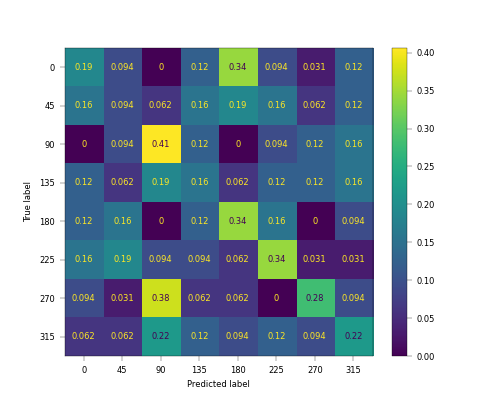

In [341]:
skmetrics.plot_confusion_matrix(trained_svc, test_data, test_labels, 
                                normalize='true')  

In [11]:
def wraper_func(func, **kwargs):
    output = func(**kwargs)
    return output

In [20]:
def func1(x='Func1', y='Alt1', z='Extra1'):
    res = '%s_%s_%s' % (x, y, z)
    return res

def func2(x='Func2', y='Alt2', w='Extra2'):
    res = '%s_%s_%s' % (x, y, z)
    r2 = 'andthis'
    return res, r2

In [23]:
inargs = {'x': 'check1', 'z': 'check2'}
inargs = (x='check1', y='check2')
res = wraper_func(func1, **inargs)
res

SyntaxError: invalid syntax (<ipython-input-23-0a6f99e4a23c>, line 2)

In [22]:
res = wraper_func(func2, **inargs)
res

TypeError: func2() got an unexpected keyword argument 'z'

In [ ]:
decode_from_fov(dk, va, neuraldf, sdf, C_value=C_value,
                        n_iterations=n_iterations, n_processes=n_processes, results_id=results_id,
                        class_a=class_a, class_b=class_b, do_shuffle=do_shuffle,
                        rootdir=rootdir, verbose=verbose,
                        test_type=test_type, n_train_configs=n_train_configs) 
            print("--- done by_fov ---")